## **Kaggle API Setup**

First, we place 'kaggle.json' in the google collab project folder by creating new API token from our respective kaggle account

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Downloading the dataset

Now, we download the dataset from kaggle using the following command

In [1]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:49<00:00, 24.7MB/s]
100% 1.06G/1.06G [00:49<00:00, 23.2MB/s]


## **Importing Libraries**

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import Xception
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# extracting content from the zip file

zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## DataFrame Creation

In [4]:


# Define the path to the training directory
train_dir = "/content/train/"

# Initialize lists to hold image names and labels
image_names = []
labels = []

# Loop through each folder (label) in the directory
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):  # Ensure it's a folder
        for image_name in os.listdir(label_path):
            # Append the image name and label to the lists
            image_names.append(image_name)
            labels.append(label)

# Create a DataFrame
df = pd.DataFrame({
    "image_name": image_names,
    "label": labels
})

# Display the first few rows
print(df)


          image_name label
0       cat.5231.jpg  cats
1       cat.2724.jpg  cats
2      cat.10844.jpg  cats
3       cat.9197.jpg  cats
4       cat.4566.jpg  cats
...              ...   ...
19995  dog.12084.jpg  dogs
19996   dog.3853.jpg  dogs
19997   dog.7778.jpg  dogs
19998   dog.2245.jpg  dogs
19999   dog.8899.jpg  dogs

[20000 rows x 2 columns]


In [5]:
# Checking duplicates here
df.duplicated().sum()

0

Lets check our target classes distribution

<ipython-input-6-2ea647fa7092>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="Set1")


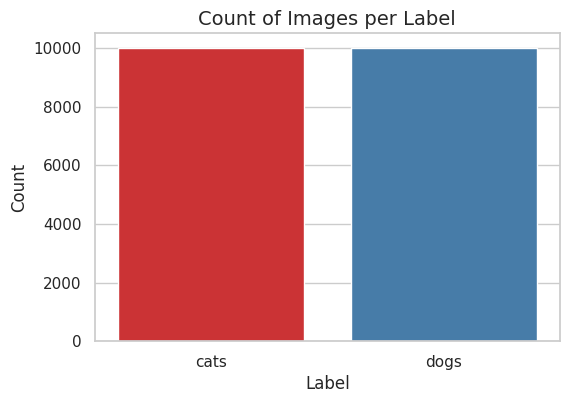

In [6]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="label", palette="Set1")

# Add title and labels
plt.title("Count of Images per Label", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show the plot
plt.show()

The above dataset is perfectly balanced

## **Dogs and Cats Sample Images**

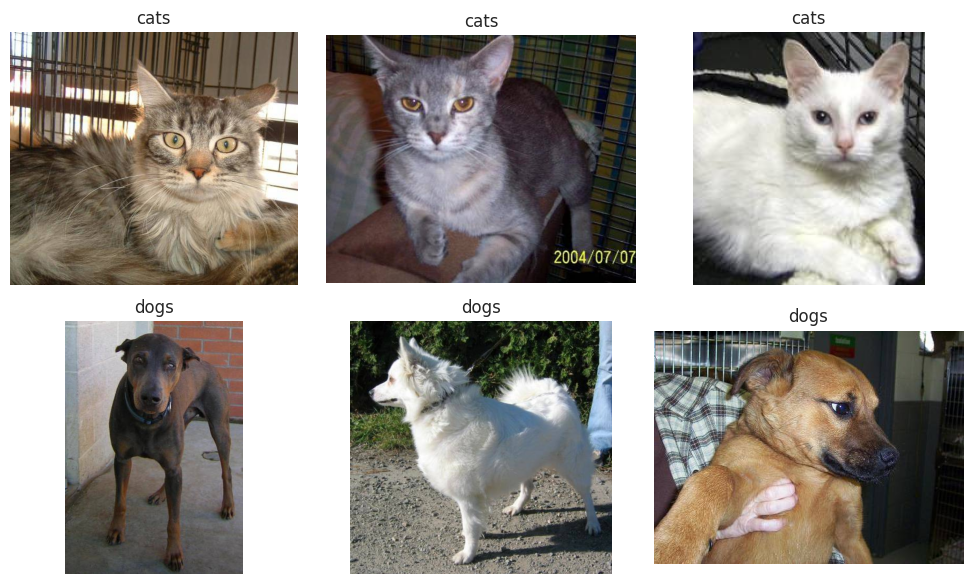

In [7]:
cat_images = df[df["label"] == "cats"].head(3)
dog_images = df[df["label"] == "dogs"].head(3)

# Combine the DataFrames
selected_images = pd.concat([cat_images, dog_images])

# Plot the images
plt.figure(figsize=(10, 6))
for i, row in enumerate(selected_images.itertuples(), start=1):
    # Load each image
    image_path = os.path.join(train_dir, row.label, row.image_name)
    img = mpimg.imread(image_path)

    # Display the image
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Data Augmentation**

In [8]:
# data augmentation

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## **Transfer Learning using Pretained model: Xception**

In [9]:
conv_base = Xception(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

conv_base.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Now, we feed the pretrained model to our dense layer architecture

In [10]:
model = Sequential()

model.add(conv_base)
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256,activation='relu', kernel_initializer= 'he_normal'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## **Model Architecture**

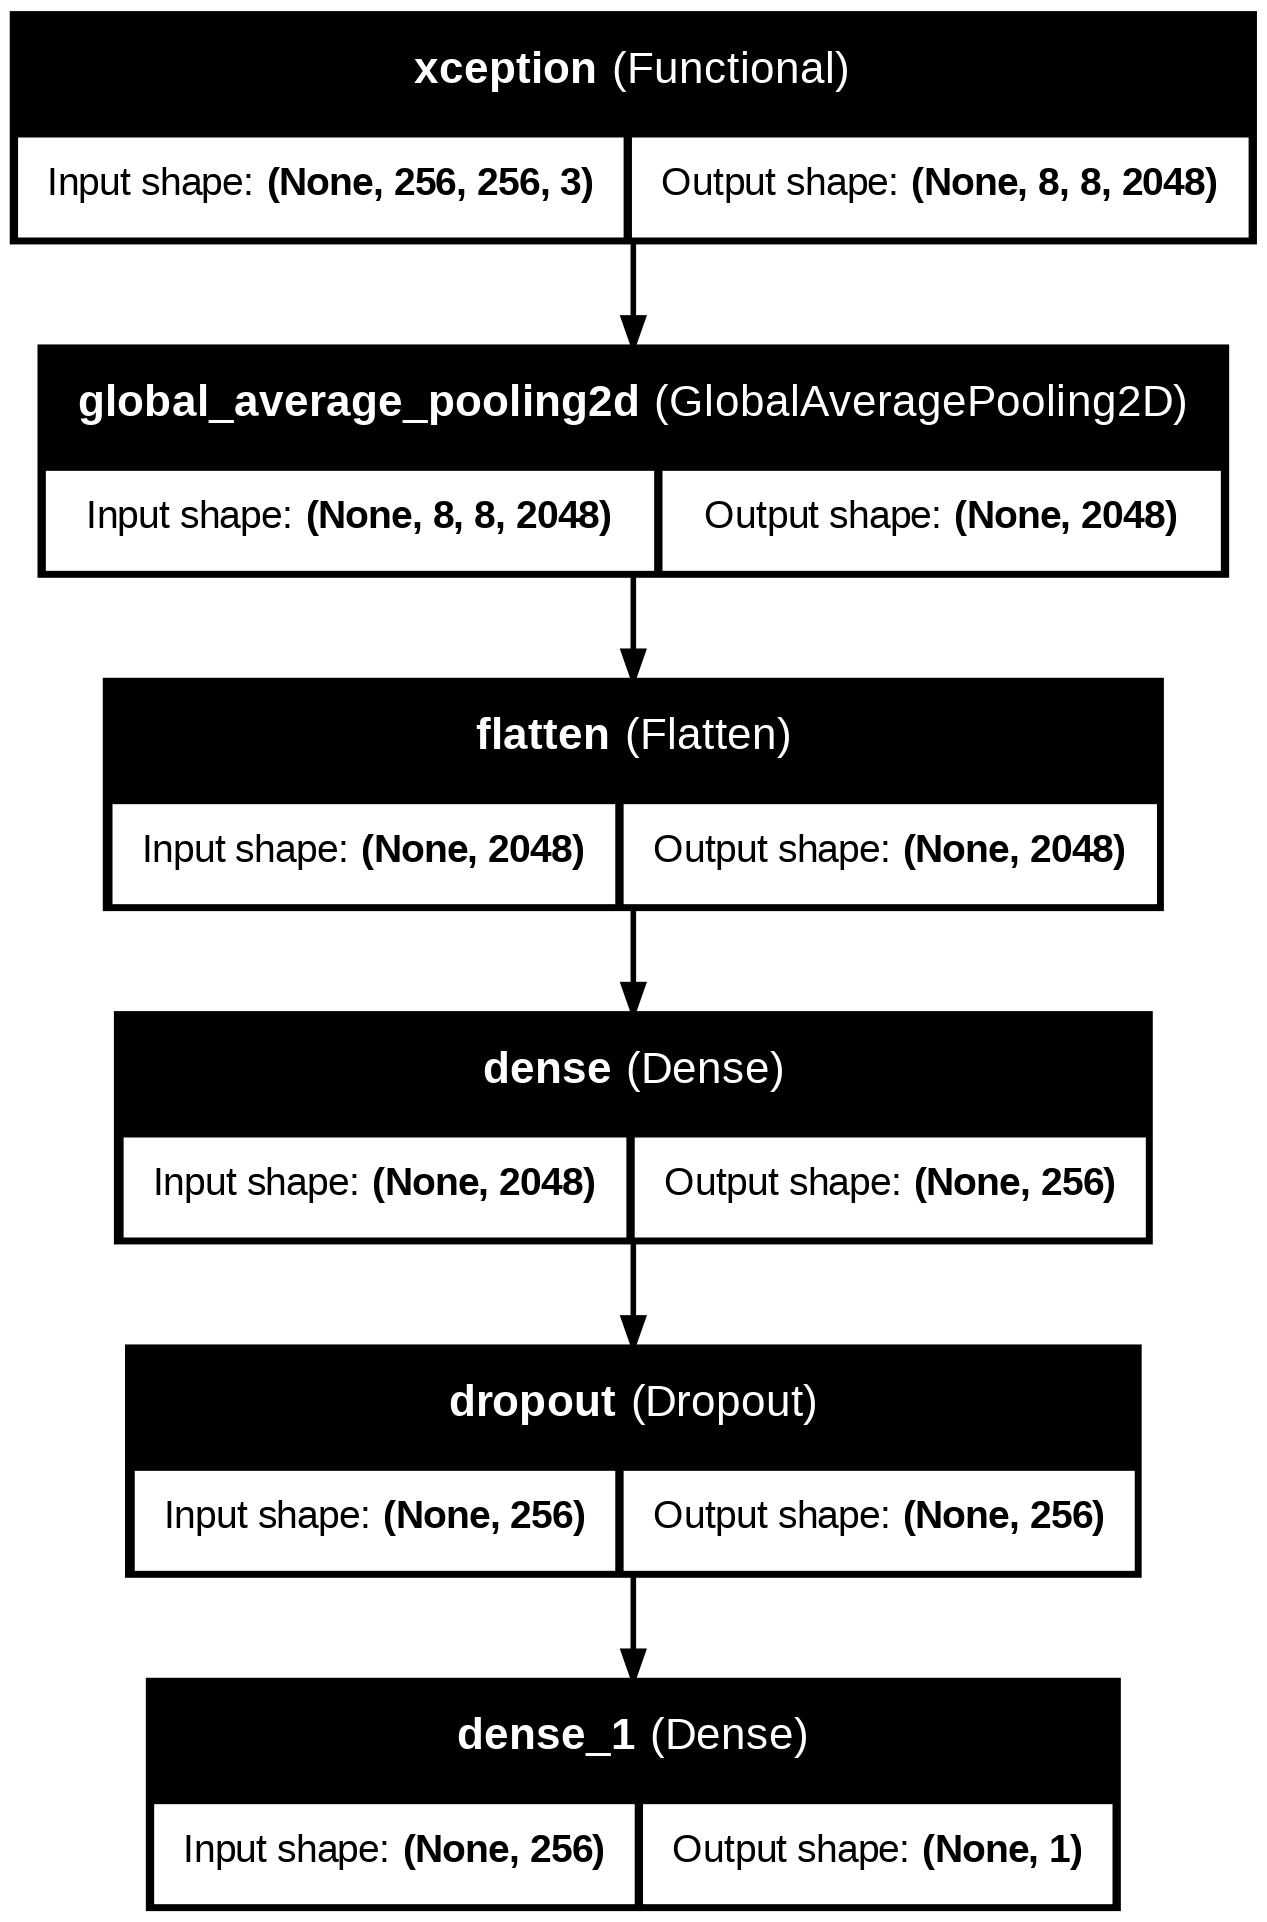

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)


In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss ='binary_crossentropy',metrics = ['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss',     # Monitor validation loss
                               patience=3,             # Number of epochs without improvement
                               restore_best_weights=True)

In [17]:
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',     # Monitor validation loss
                              factor=0.05,             # Reduce learning rate by a factor of 0.5
                              patience=2,             # Wait 2 epochs before reducing the learning rate
                              min_lr=0.0001)          # Minimum learning rate limit

In [18]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]  # Add early stopping and learning rate reduction callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 378s 569ms/step - accuracy: 0.9720 - loss: 0.0722 - val_accuracy: 0.9902 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 552ms/step - accuracy: 0.9876 - loss: 0.0365 - val_accuracy: 0.9900 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 350s 556ms/step - accuracy: 0.9888 - loss: 0.0306 - val_accuracy: 0.9898 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 554ms/step - accuracy: 0.9886 - loss: 0.0316 - val_accuracy: 0.9912 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 348s 550ms/step - accuracy: 0.9890 - loss: 0.0309 - val_accuracy: 0.9844 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 354s 560ms/step - accuracy: 0.9872 - loss: 0.0348 - val_accuracy: 0.9908 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 378s 553ms/step - accuracy: 0.9912 

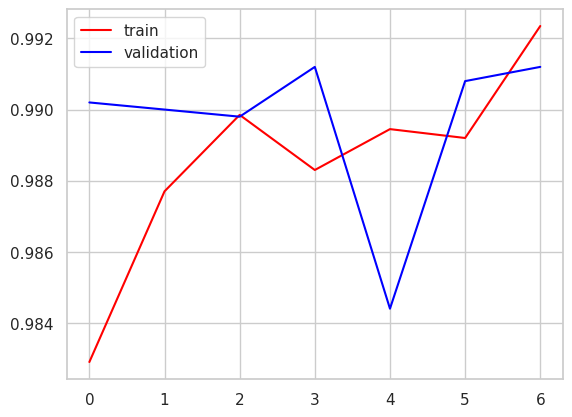

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

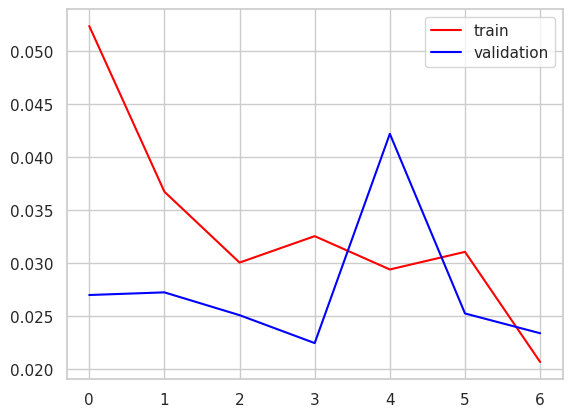

In [20]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


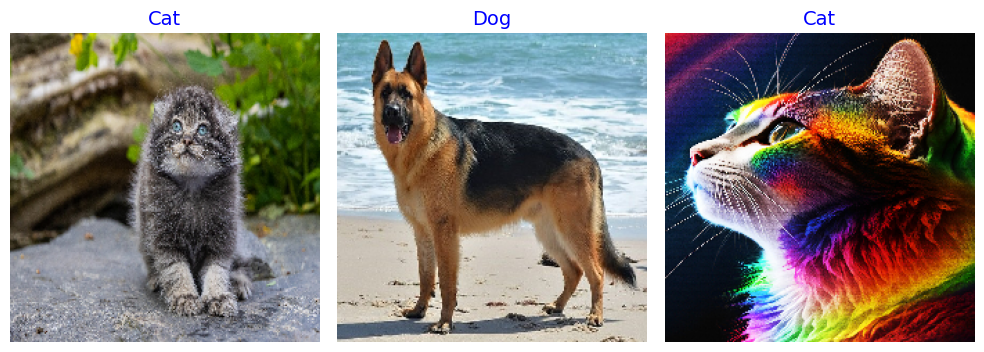

In [27]:
# Function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Adjust size to match your model's input
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    return img_array

# Paths to the three unseen images
image_paths = [
    '/content/cat_1.jpg',
    '/content/dog_1.jpeg',
    '/content/cat_2.jpg'
]

# Preprocess all images
images = [preprocess_image(path) for path in image_paths]
images_batch = np.stack(images)  # Shape will become (3, 224, 224, 3)

# Make predictions
predictions = model.predict(images_batch)

# Output the results (assuming binary classification: 0 for cat, 1 for dog)
labels = ['Cat' if pred <= 0.5 else 'Dog' for pred in predictions]

# Plot images with predicted labels
plt.figure(figsize=(10, 5))
for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(1, 3, i + 1)  # Arrange in 1 row, 3 columns
    plt.imshow(img)
    plt.title(label, fontsize=14, color='blue')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
import pickle

# Assuming 'model' is your trained classifier
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully!")


Model saved successfully!
